# WO Mart sales prediction ML modelling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

## Import Data

In [2]:
train=pd.read_csv('TRAIN.csv')
test=pd.read_csv('TEST_FINAL.csv')

# EDA

In [3]:
train.shape, test.shape

((188340, 10), (22265, 8))

In [4]:
train.isnull().sum(), test.isnull().sum()

(ID               0
 Store_id         0
 Store_Type       0
 Location_Type    0
 Region_Code      0
 Date             0
 Holiday          0
 Discount         0
 #Order           0
 Sales            0
 dtype: int64,
 ID               0
 Store_id         0
 Store_Type       0
 Location_Type    0
 Region_Code      0
 Date             0
 Holiday          0
 Discount         0
 dtype: int64)

* No missing values

In [5]:
train.dtypes

ID                object
Store_id           int64
Store_Type        object
Location_Type     object
Region_Code       object
Date              object
Holiday            int64
Discount          object
#Order             int64
Sales            float64
dtype: object

In [6]:
#Let's drop #Order column from train data as it's not available in test data
train.drop('#Order', axis=1,inplace=True)

In [7]:
#Let's convert object type categorical variables to type 'Category'
var=['Store_Type','Location_Type','Region_Code','Discount']
for i in var:
    train[i]=train[i].astype('category')
    test[i]=test[i].astype('category')

In [8]:
#Let's see sample data
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,45614.52


In [9]:
#Converting date field to type DateTime
train['Date']=pd.to_datetime(train['Date'])
test['Date']=pd.to_datetime(test['Date'])

In [10]:
#Deriving different useful dimensions from Date field like Month, Day of week and day of month
train['Month']=train['Date'].dt.month
test['Month']=test['Date'].dt.month

train['dayofmonth']=train['Date'].dt.day
test['dayofmonth']=test['Date'].dt.day

train['dayofweek']=train['Date'].dt.dayofweek
test['dayofweek']=test['Date'].dt.dayofweek

In [11]:
#Let's see if we have hour of day info available
train['Date'].dt.hour.value_counts()

0    188340
Name: Date, dtype: int64

* No hour info available as we see all values defaulting to zero

<AxesSubplot:xlabel='dayofweek'>

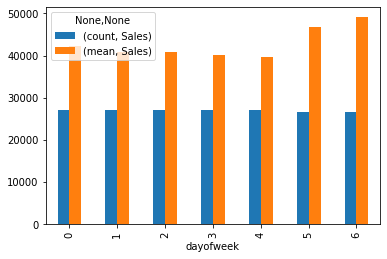

In [12]:
train.pivot_table('Sales','dayofweek',aggfunc=['count','mean']).plot(kind='bar')

* day of week seem to have an impact on Sales. Weekends (Saturday and Sunday) have a higher sales value

<AxesSubplot:xlabel='Month'>

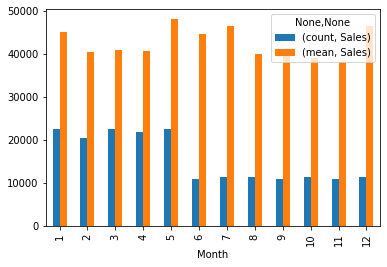

In [13]:
train.pivot_table('Sales','Month',aggfunc=['count','mean']).plot(kind='bar')

* Month also has a bearing on Sales as we see average Sales vary across months

<AxesSubplot:xlabel='dayofmonth'>

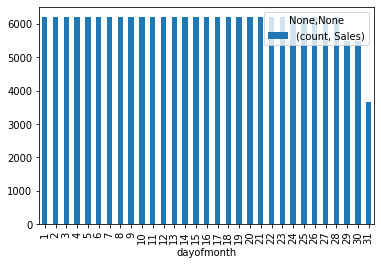

In [14]:
train.pivot_table('Sales','dayofmonth',aggfunc=['count']).plot(kind='bar')

<AxesSubplot:xlabel='dayofmonth'>

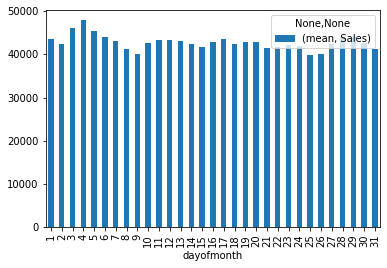

In [15]:
train.pivot_table('Sales','dayofmonth',aggfunc=['mean']).plot(kind='bar')

* There is no pattern as such in Sales average across day of month. However, we see average varies across different days

<AxesSubplot:xlabel='Discount'>

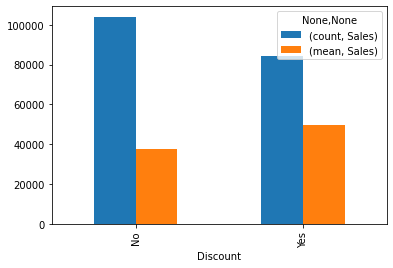

In [16]:
train.pivot_table('Sales','Discount',aggfunc=['count','mean']).plot(kind='bar')

* Count of no Discount is more however, average of sale is more for Discounted ones

<AxesSubplot:xlabel='Store_Type'>

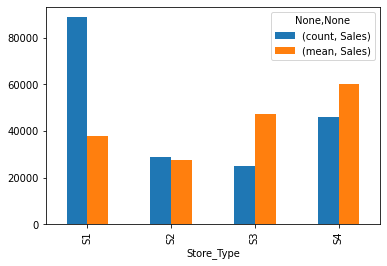

In [17]:
train.pivot_table('Sales','Store_Type',aggfunc=['count','mean']).plot(kind='bar')

* S1 store type has more sales count however S4 store has a higher average sales amount

<AxesSubplot:xlabel='Location_Type'>

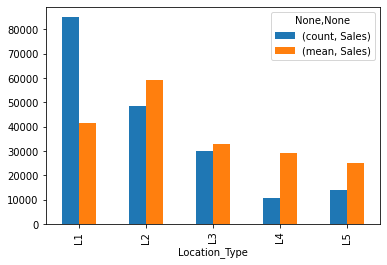

In [18]:
train.pivot_table('Sales','Location_Type',aggfunc=['count','mean']).plot(kind='bar')

<AxesSubplot:xlabel='Region_Code'>

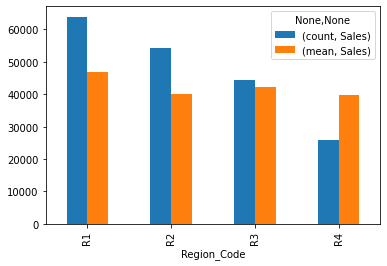

In [19]:
train.pivot_table('Sales','Region_Code',aggfunc=['count','mean']).plot(kind='bar')

In [20]:
#Let's drop ID and Date columns as these don't has absolute relation. All relevant info from Date has already been derived
train.drop('ID',axis=1,inplace=True), test.drop('ID',axis=1,inplace=True)
train.drop('Date',axis=1,inplace=True), test.drop('Date',axis=1,inplace=True)

(None, None)

<AxesSubplot:xlabel='Holiday'>

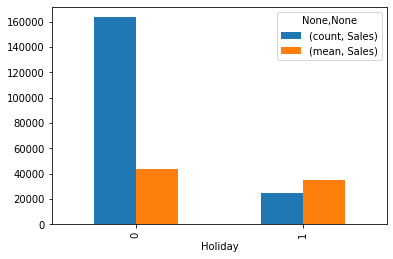

In [21]:
train.pivot_table('Sales','Holiday',aggfunc=['count','mean']).plot(kind='bar')

* No much impact of Holiday's on Sale is observed. Sales number of more on non-holiday as we have less holidays and more non-holiday dates

<AxesSubplot:xlabel='Sales', ylabel='Density'>

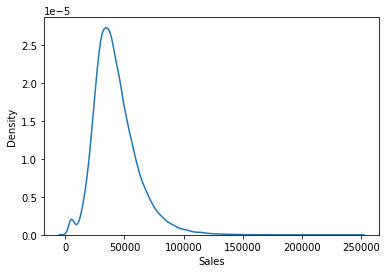

In [22]:
sns.kdeplot(train.Sales)

* Target variable has outliers which makes it right skewed. We will have to address this to avoid misleaving the predictions

In [23]:
# Let's understand the spread of data by spotting .99 quantile value, max and min values
train.Sales.quantile(.99), train.Sales.max(), train.Sales.min()

(102159.0, 247215.0, 0.0)

In [24]:
train.loc[train.Sales>=102159.0, 'Sales']=102159.0

* Let's update all outliers with .99 quantile value to fix right skewness

<AxesSubplot:xlabel='Sales', ylabel='Density'>

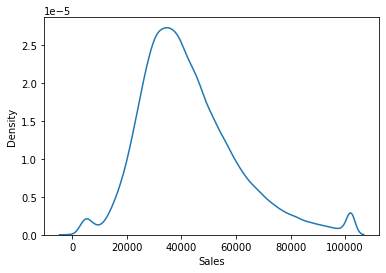

In [25]:
sns.kdeplot(train.Sales)

* Now target variable looks more normal (with little bumps at both ends ofcourse which can be ignored)

# Pre-processing

In [26]:
# Let's get categorical values encoded to be ready for model building
train=pd.get_dummies(train,columns=['Store_Type','Location_Type','Region_Code','Discount','dayofweek','dayofmonth'])

In [27]:
test=pd.get_dummies(test, columns=['Store_Type','Location_Type','Region_Code','Discount', 'dayofweek', 'dayofmonth'])

In [28]:
test.columns

Index(['Store_id', 'Holiday', 'Month', 'Store_Type_S1', 'Store_Type_S2',
       'Store_Type_S3', 'Store_Type_S4', 'Location_Type_L1',
       'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4',
       'Location_Type_L5', 'Region_Code_R1', 'Region_Code_R2',
       'Region_Code_R3', 'Region_Code_R4', 'Discount_No', 'Discount_Yes',
       'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3',
       'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'dayofmonth_1',
       'dayofmonth_2', 'dayofmonth_3', 'dayofmonth_4', 'dayofmonth_5',
       'dayofmonth_6', 'dayofmonth_7', 'dayofmonth_8', 'dayofmonth_9',
       'dayofmonth_10', 'dayofmonth_11', 'dayofmonth_12', 'dayofmonth_13',
       'dayofmonth_14', 'dayofmonth_15', 'dayofmonth_16', 'dayofmonth_17',
       'dayofmonth_18', 'dayofmonth_19', 'dayofmonth_20', 'dayofmonth_21',
       'dayofmonth_22', 'dayofmonth_23', 'dayofmonth_24', 'dayofmonth_25',
       'dayofmonth_26', 'dayofmonth_27', 'dayofmonth_28', 'dayofmonth_29',
       'da

In [29]:
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_log_error as msle

# Model Building

In [30]:
x=train.drop('Sales',axis=1)
y=train['Sales']

In [31]:
x_train,x_test,y_train,y_test=tts(x,y,test_size=.3,random_state=45)

In [32]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((131838, 56), (131838,), (56502, 56), (56502,))

## Linear regression

In [33]:
model=LR(normalize=True)
model.fit(x_train,y_train)
train_pred_LR=model.predict(x_train)
test_pred_LR= model.predict(x_test)
train_score=msle(train_pred_LR,y_train)*1000
test_score=msle(test_pred_LR,y_test)*1000
print('Train Scre: ',train_score, 'Test Score: ',test_score)

Train Scre:  106.23457089359408 Test Score:  103.77920635499338


* It has worked reasonable good. But we can still explore other models before concluding

In [34]:
ft=x.columns
cf=model.coef_
coef=pd.DataFrame({'Features':ft, 'coef':cf})

<BarContainer object of 56 artists>

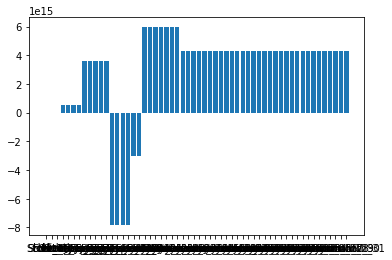

In [35]:
plt.bar(coef.Features, coef.coef)

* Most of the dimensons seem to have a good correlation. Worth considering all

## Ridge model

In [36]:
from sklearn.linear_model import Ridge

train_score=[]
test_score=[]
alpha=[]
for i in [1e-4, 1e-2, 1e-1, 1, 2]:
    modelR=Ridge(alpha=i, normalize=True)
    modelR.fit(x_train,y_train)
    train_pred=modelR.predict(x_train)
    test_pred=modelR.predict(x_test)
    train_score.append(msle(train_pred,y_train)*1000)
    test_score.append(msle(test_pred,y_test)*1000)
    alpha.append(i)

Scores={'alpha':alpha, 'train_score':train_score, 'test_score':test_score}
print(pd.DataFrame(Scores))

    alpha  train_score  test_score
0  0.0001   106.272465  103.821511
1  0.0100   106.267511  103.819637
2  0.1000   106.849505  104.401528
3  1.0000   126.449748  123.625225
4  2.0000   145.267849  142.188761


* With different alpha values we can see .01 gives best performance. But no significant gain over general model

## Lasso

In [37]:
from sklearn.linear_model import Lasso
train_score=[]
test_score=[]
alpha=[]
for i in [1e-4, 1e-2, 1e-1, 1, 2]:
    modelL=Lasso(alpha=i, normalize=True)
    modelL.fit(x_train,y_train)
    train_pred=modelL.predict(x_train)
    test_pred=modelL.predict(x_test)
    train_score.append(msle(train_pred,y_train)*1000)
    test_score.append(msle(test_pred,y_test)*1000)
    alpha.append(i)

Scores={'alpha':alpha, 'train_score':train_score, 'test_score':test_score}
print(pd.DataFrame(Scores))

    alpha  train_score  test_score
0  0.0001   106.272642  103.821636
1  0.0100   106.279736  103.827158
2  0.1000   106.400026  103.932761
3  1.0000   109.694262  107.075042
4  2.0000   113.881852  111.121159


* With differet alpha values .0001 seems to give better formance. But inline with Ridge no major gain

## Decision Tree

In [38]:
from sklearn.tree import DecisionTreeRegressor as TR

train_score=[]
test_score=[]
mx_dpth=[5, 8, 10, 12, 15, 18, 20]
for i in mx_dpth:
    modelTR=TR(random_state=30, max_depth=i)
    modelTR.fit(x_train, y_train)
    train_pred=modelTR.predict(x_train)
    test_pred=modelTR.predict(x_test)
    train_score.append(msle(train_pred,y_train)*1000)
    test_score.append(msle(test_pred,y_test)*1000)

Scores={'Max_Depth':mx_dpth, 'Train_Score':train_score, 'Test_Score':test_score}
print(pd.DataFrame(Scores))

   Max_Depth  Train_Score  Test_Score
0          5   118.776485  115.613267
1          8    86.405190   83.790042
2         10    70.124771   69.275945
3         12    59.371679   63.337859
4         15    45.435864   63.903943
5         18    32.930813   69.897181
6         20    25.808480   78.375207


* Decision tree with max depth 12 gives a significant improvement in the performance when compared to linear models

## Ensembling with Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

train_score=[]
test_score=[]
n_estimators=[]
max_depth=[]

for i in [20,25,30,35,40]:
    for j in [10,15,20,25]:
        modelRF=RandomForestRegressor(random_state=101, n_estimators=i, max_depth=j)
        modelRF.fit(x_train,y_train)
        train_pred=modelRF.predict(x_train)
        test_pred=modelRF.predict(x_test)
        train_score.append(msle(train_pred, y_train))
        test_score.append(msle(test_pred,y_test))
        n_estimators.append(i)
        max_depth.append(j)

Score={'n_estimators':n_estimators, 'max_depth':max_depth, 'Train_Score':train_score, 'test_score':test_score}

In [41]:
print(pd.DataFrame(Score).sort_values('test_score'))

    n_estimators  max_depth  Train_Score  test_score
19            40         25     0.022981    0.051304
15            35         25     0.023009    0.051417
18            40         20     0.031744    0.051437
11            30         25     0.023106    0.051489
14            35         20     0.031775    0.051522
10            30         20     0.031813    0.051577
7             25         25     0.023210    0.051702
6             25         20     0.031874    0.051715
2             20         20     0.031951    0.051897
3             20         25     0.023346    0.051927
17            40         15     0.045591    0.053852
9             30         15     0.045634    0.053911
13            35         15     0.045614    0.053933
5             25         15     0.045723    0.054040
1             20         15     0.045794    0.054149
4             25         10     0.068728    0.068193
0             20         10     0.068826    0.068258
8             30         10     0.068880    0.

* Random forest with 40 trees and 15 max_depth gives the best performance of all that we have tried

In [43]:
from sklearn.ensemble import RandomForestRegressor
modelRF=RandomForestRegressor(random_state=101, n_estimators=40
                              , max_depth=15)
modelRF.fit(x_train,y_train)
train_pred=modelRF.predict(x_train)
test_pred=modelRF.predict(x_test)
train_score=msle(train_pred, y_train)
test_score=msle(test_pred,y_test)
print(train_score, ' ', test_score)

0.04559092182274675   0.05385174342497422


In [44]:
submission = pd.read_csv('SAMPLE.csv')
final_predictions = modelRF.predict(test)
submission['Sales'] = final_predictions
#only positive predictions for the target variable
submission['Sales'] = submission['Sales'].apply(lambda x: 0 if x<0 else x)
submission.to_csv('my_submission.csv', index=False)